In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


# Loading the dataset

In [3]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Deeper Network (2 hidden layers)

To get from the perceptron to mlp we expanded the model with many parallel matrix operations. Now we can try to make it deeper, with more operations happening in series. <br>
This is especially poerful because biological neurons fire around 100 times a second, it takes a human 100ms to identify an object, so it stands to reason that a 10 layer network should be able to do complex tasks.  

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 2

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())


4.162832260131836
2.2495663166046143
1.9945460557937622
1.8634577989578247
1.783164143562317
1.6933749914169312
1.6564230918884277
1.6653659343719482
1.6169850826263428
1.6268047094345093


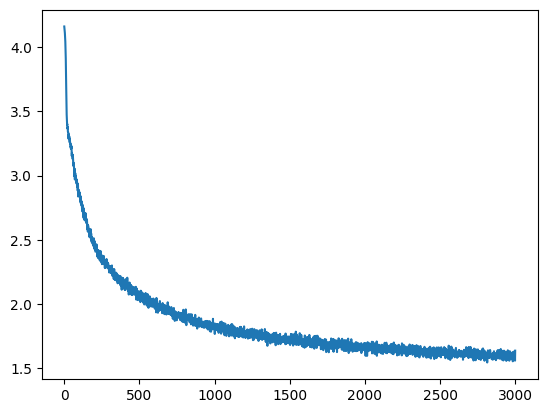

In [6]:
plt.plot(lossi)

# Much deeper network (20 layers)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 20

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

4.1871490478515625
3.326489210128784
2.704951047897339
2.550448179244995
2.5508973598480225
2.705822706222534
2.5749917030334473
2.509667158126831
2.4813246726989746
2.459918260574341


The network with 20 hidden layers is unable to train effectively, thats because the derivatives don't flow well between the layers

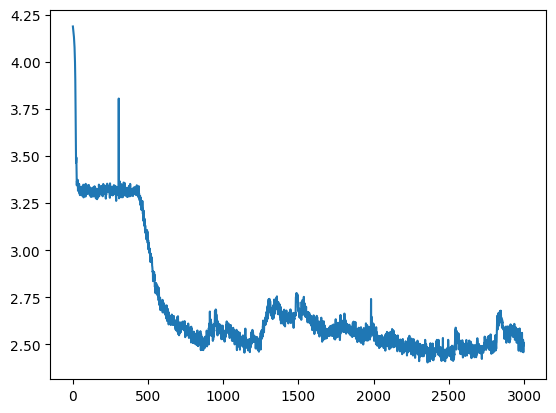

In [8]:
plt.plot(lossi)

# Residual connections

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 20

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for fc in self.fcx:
            x = x + F.gelu(fc(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())


4.923676013946533
1.8530547618865967
1.6279900074005127
1.5139198303222656
1.4944146871566772
1.4644240140914917
1.3738453388214111
1.3969645500183105
1.392985224723816
1.31560218334198


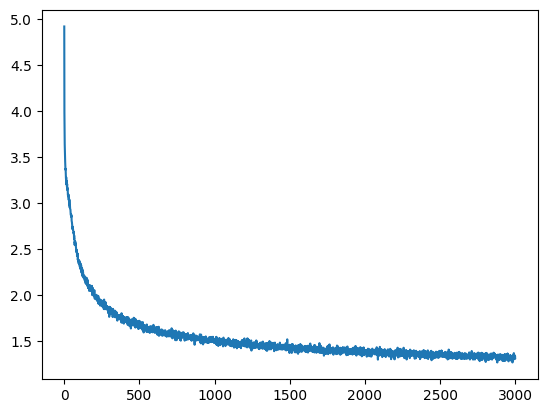

In [10]:
plt.plot(lossi)

# Deeper (56 layers) 

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 56

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for fc in self.fcx:
            x = x + F.gelu(fc(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

18127.5
3.4516892433166504
3.242292881011963
3.108473300933838
3.0635063648223877
2.9675934314727783
2.9284980297088623
2.8536200523376465
2.7540504932403564
2.6695287227630615


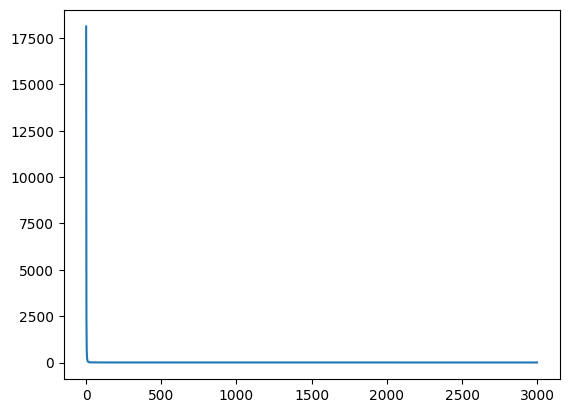

In [12]:
plt.plot(lossi[:])

deeper connections allow us to go up to crazy amounts of layers, but we instantly notice the CRAZY high loss at the start, we solved this problem before by decreasing the parameter values at initialization, but if we go down more we are going to get extremely low values. Restricting the flow of information through the network<br><br>
We want the information in the neurons to travel through the network while not getting blown out to crazy high values. To do that we can normalize the neurons with layernorm, so that std = 1 and mean = 0

In [13]:
class Block(nn.Module):
    def __init__(self, layers, hidden_size):
        super().__init__()
        hidden_size = 128
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(layers)])
    
    def forward(self, x):
        for fc in self.fcx:
            x = x + F.gelu(fc(x))
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 56
        n_blocks = 9
        blocksize = n_layers//n_blocks

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.blocks = nn.ModuleList([Block(blocksize, hidden_size) for _ in range(n_blocks)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for block in self.blocks:
            x = block(self.norm(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

4.816093921661377
1.9981305599212646
1.6715484857559204
1.6189942359924316
1.511489748954773
1.459238886833191
1.4279966354370117
1.3886162042617798
1.3643871545791626
1.3724814653396606


In [14]:
string = "             \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        #print(X)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


             
KING RICHARD II:
And were supposed out not, more we may you, ay.

DERBARe as
he dukedom ere the
meremonus' souls of succession in the white three part for I fear; come, resires wound of my fortune!

YORKOLANUS:
Muth of God familinabcence!
That not would me, I lampests we king's forrow I pray,
She will citizen:
Ma

# WAYY TOO DEEP
Just for fun lets try way more layers

In [15]:
class Block(nn.Module):
    def __init__(self, layers, hidden_size):
        super().__init__()
        hidden_size = 128
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(layers)])
    
    def forward(self, x):
        for fc in self.fcx:
            x = x + F.gelu(fc(x))
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 10
        hidden_size = 128
        n_layers = 200
        blocksize = 5
        n_blocks = n_layers//blocksize

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc1 = nn.Linear(emb_size*sequence_length, hidden_size)
        self.blocks = nn.ModuleList([Block(blocksize, hidden_size) for _ in range(n_blocks)])
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc1(emb))
        for block in self.blocks:
            x = block(self.norm(x))
        return self.fc2(x)


device = torch.device("cuda:0")
model = Model().to(device)

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        vloss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(vloss.item())

4.336365699768066
2.522479772567749
2.129979372024536
1.8817771673202515
1.7472091913223267
1.668614149093628
1.5892407894134521
1.5906329154968262
1.525301218032837
1.5340937376022339


# Limits to scale
The model clearly has problems backpropagating the gradients effectively. You may be able to make it work with some weird trick but there are solutions that scale much better. 